# Huiswerk opdracht Fries naar Nederlands vertalen

### Notebook by [Iris Oerlemans](http://www.google.com/)

---

## Table of contents

1. [Business Understanding](#Business-Understanding)

2. [Data Understanding](#Data-Understanding)

3. [Data Prepartion](#Data-Preparation)

4. [Modeling & Evaluation](#Modeling-&-Evaluation)

---

# Business Understanding

[[ go back to the top ]](#Table-of-contents)

De vraag van de klant is: Kan machine learning helpen bij het vertalen van brieven en teksten die gescheven zijn in een andere taal dan de ontvanger spreekt? 

Voor de opdracht maken we gebruik van de dataset van het [Fryske Akademy](https://frisian.eu/). Deze dataset bestaat uit zin-paren van Nederlands naar Fries. 

De opdracht is: verbeter de kwaliteit van de automatische vertaler tussen het Nederlands en Fries **(of andersom)**.

Als oplevering verwacht de opdrachtgever een aantal zinnen gedemonstreert. 

---

In [1]:
# Data Manipulation and Analysis
import pandas as pd 
import numpy as np 

# Machine Learning and Data Preprocessing
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 

# Visualization
import matplotlib.pyplot as plt 

# AI packages
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import keras_nlp
from tensorflow.keras.callbacks import EarlyStopping


# Project-Specific Modules
import requests
import unicodedata
from sklearn.model_selection import train_test_split
import string
import re

from transformers import BartTokenizer, TFBartForConditionalGeneration
import torch
from torch.utils.data import Dataset, DataLoader
import random
from collections import Counter

2024-10-11 09:27:06.537367: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 09:27:06.710000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 09:27:06.772540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 09:27:06.787932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 09:27:06.886121: I tensorflow/core/platform/cpu_feature_guar

---

# Data Understanding

[[ go back to the top ]](#Table-of-contents)

Data inladen volgens geleverde bestanden.

---

Dataframe maken

In [2]:
df_pd = pd.read_csv('dataset.csv')
df_pd.head()

,nederlands,fries
0,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
1,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
2,een plotselinge dood,in hastige dea
3,een plotselinge dood,in unferwachte dea
4,zijn plotseling overlijden,syn hastich ferstjerren


Kijken hoe groot de dataset.csv is

In [3]:
len(df_pd)

173912

Kijken hoe groot de txt is

In [4]:
text_file = "texts.txt"

with open(text_file, encoding='utf8') as f:
    lines = f.readlines() 

print(len(lines))

195545


Rekening houdend met dat de teksten onder elkaar staan en dus /2 moet eigenlijk, kan tekst.txt beter het test bestand worden en dataset.csv beter het train bestand.

In [5]:
df_pd.isnull().sum()

nederlands    0
fries         0
dtype: int64

In [6]:
print(df_pd['nederlands'].str.len().max())
print(df_pd['nederlands'].str.len().min())

390
3


In [7]:
print(df_pd['fries'].str.len().max())
print(df_pd['fries'].str.len().min())

354
1


Ik heb chatgpt gevraagd om mij te helpen bij het vinden van speciale tekens. 

# Data Preparation

[[ go back to the top ]](#Table-of-contents)

---

De volgende stap heb ik gevolgd zoals in de les uitgelegd. Wel heb ik onderzocht waarom we [start] en [end] toevoegen. Dit bleek niet verplicht te zijn, maar handig om de decoder beter zijn werk te laten doen. Daarom heb ik gekozen om dit erin te laten staan. 

In het volgende stuk code verwerk ik het tekst bestand, wat ik als trainingsdata ga gebruiken. Het bestand hiervoor ga ik gebruiken als testdata. 
Ik heb hierin Fries als originele taal gepakt om dit te kunnen vertalen naar het Nederlands zodat casussen als de brief (zie opdracht) via deze weg vertaald kunnen worden naar het Nederlands.

In [8]:
text_file = "texts.txt"
text_pairs_test = []
current_translation = None

with open(text_file, encoding='utf8') as f:
    lines = f.read().split("\n")[:-1]


for line in lines:
    #als regel niet met tr begint = Nederlands
    if not line.startswith("tr:"):
        current_translation = "[start] " + line + " [end]"  
    #als regel met tr begint is het de Friese zin 
    elif current_translation:  
        fries = line.replace("tr: ", "")
        text_pairs_test.append((fries, current_translation))

text_pairs_test[:5]


[("Dat leste hat it tastel noch twa kear foar by de makker west: it foldocht neffens de [reparaasjetsjinst, makkerstsjinst, makkerij] perfekt oan 'e technyske spesifikaasjes.",
  '[start] Voor dit laatste is het toestel nog twee keer in herstelling geweest: het voldoet volgens de hersteldienst perfect aan de technische specificaties. [end]'),
 ('Us [reparaasjetsjinst, makkerstsjinst, makkerij] stiet klear om dizze maleur sa gau mooglik by te helpen.',
  '[start] Onze hersteldienst staat klaar om dit defect zo snel mogelijk op te lossen. [end]'),
 ('Us makkers steane klear om dizze maleur sa gau mooglik by te helpen.',
  '[start] Onze hersteldienst staat klaar om dit defect zo snel mogelijk op te lossen. [end]'),
 ('Lytse [reparaasjetsjinsten, makkerstsjinsten, makkerijen] by fytsen, fuotark en learguod, klean en hushaldlik linnen.',
  '[start] Kleine hersteldiensten bij fietsen, schoeisel en lederwaren, kleding en huishoudlinnen. [end]'),
 ('De earetsjinst, de hielingstsjinsten, it lea

Omzetten csv bestand, zodat dit uiteindelijk te gebruiken is als test data.

In [9]:
text_pairs_train = []

for index, row in df_pd.iterrows():
    fries = row['fries']  
    nederlands = "[start] " + row['nederlands'] + " [end]"  
    text_pairs_train.append((fries, nederlands))

text_pairs_train[:5]


[('wy hawwe de boargemaster it advys jun om it kafee tydlik te sluten sei de stedsamtner',
  '[start] we hebben de burgemeester het advies gegeven om het cafe tijdelijk te sluiten aldus de stadsambtenaar [end]'),
 ('wy hawwe de boargemaster it advys jun om it kafee tydlik te sluten seit de stedsamtner',
  '[start] we hebben de burgemeester het advies gegeven om het cafe tijdelijk te sluiten aldus de stadsambtenaar [end]'),
 ('in hastige dea', '[start] een plotselinge dood [end]'),
 ('in unferwachte dea', '[start] een plotselinge dood [end]'),
 ('syn hastich ferstjerren', '[start] zijn plotseling overlijden [end]')]

Het splitten van de train en test data heb ik in feite dus nu al gedaan. En zoals te zien is staan ze in hetzelfde format.

Nu ga ik de standardization voorbereiden en een functie van schrijven. Hiermee normaliseer ik de tekst. Daarna zet ik de zinnen om in tokens zodat ze kunnen worden verwerkt zometeen.

In [10]:
#schoon de zinnen op (lowercase, interpunctie etc.) en vectorize de zinnen
#Dit stuk code komt uit het werkboek van les 3

strip_chars = string.punctuation # vewijder intterpunctie
strip_chars = strip_chars.replace("[", "") #zorgt ervoor dat de [ en ] behouden blijven
strip_chars = strip_chars.replace("]", "") 

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "") #TensorFlow-functie om tekst te manipuleren, 

vocab_size = 80000
sequence_length = 20

source_vectorization = layers.TextVectorization( 
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1, standardize=custom_standardization 
    #Generate Dutch sentences that have one extra token, since we need to offset 
    #the sentence by one step during training
)

train_fries_texts = [pair[0] for pair in text_pairs_train]
train_nl_texts = [pair[1] for pair in text_pairs_train]
source_vectorization.adapt(train_fries_texts)
target_vectorization.adapt(train_nl_texts)

I0000 00:00:1728638837.378127     577 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728638837.381722     577 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728638837.381766     577 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728638837.384467     577 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728638837.384501     577 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Om de gegevens efficiënter bruikbaar te maken gaan we de zinnen formateren en de dataset opnieuw opbouwen.

In [11]:
# omzetten dataset objecten
#Dit stuk code komt uit het werkboek van les 3

batch_size = 64

def format_dataset(fries, nl):
    fries = source_vectorization(fries)
    nl = target_vectorization(nl)
    return ({
        "fries": fries,
        "nl": nl[:, :-1], #the input sentence doesn't include the last token, to keep input and target the same length 
    }, nl[:, 1:]) #the target sentence is one step ahead. Both are still the same length (20 words)

def make_dataset(pairs):
    fries_texts, nl_texts = zip(*pairs)
    fries_texts = list(fries_texts)
    nl_texts = list(nl_texts)
    dataset = tf.data.Dataset.from_tensor_slices((fries_texts, nl_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset 

train_ds = make_dataset(text_pairs_train)
test_ds = make_dataset(text_pairs_test)

In [12]:
#check of alles dezelfde shape heeft
for inputs, targets in train_ds.take(1):
    print(f"inputs['fries'].shape: {inputs['fries'].shape}")
    print(f"inputs['nl'].shape: {inputs['nl'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['fries'].shape: (64, 20)
inputs['nl'].shape: (64, 20)
targets.shape: (64, 20)


2024-10-11 09:27:35.489490: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Transformer encoder

Daarna defineren we de transformer encoder. Deze bestaat al uit normalisatielagen en dense layers om de input goed te kunnen verwerken. 

In [13]:
#Dit stuk code komt uit het werkboek van les 3
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7) #MklLayerNormError FIX 
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7) #MklLayerNormError FIX 

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

#### Transformer decoder

De decoder doet twee dingen. Eerst kijkt ie naar de vorige woorden in de uitvoer en daarna koppelt ie deze naar de uitkomst van de encoder. De decoder zorgt dat het model niet kan "spieken" naar de komende woorden in de zin. 

In [14]:
#Dit stuk code komt uit het werkboek van les 3
#define de TransformerDecoder
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7)
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)
        self.layernorm_3 = layers.LayerNormalization(epsilon=1e-7)
        self.supports_masking = True #anders geen masking mogelijk

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        #prevents the model from learning to copy the next token from the input to the output by hiden it
        # [[1,0,0],
        #  [1,1,0],
        #  [1,1,1]]
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        #Replicate it along the batch axis to get an matrix of shape (batch_size, sequence_length, sequence_length)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        #retrieve the casual mask
        if mask is not None: #prepare the input mask that describes padding locations in the target_sequence
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32") #extra dim aangezien transfo deze verwacht
            padding_mask = tf.minimum(padding_mask, causal_mask)#merge both masks (input padding en volgende woord padding)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)# pass the casual mask tot the first attention layer, which performs self attention over the target sequence 
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask, #pass the combined mask to the second attention layer, which relates the source sequence to the target sequence
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

De positional embedding zorgt voor een combinatie van de token en positie. Zo weet het model niet alleen welk woord het is maar ook op welke plek in de zin het woord staat. Dit is belangrijk voor de betekenis van het woord. 

In [15]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        # Initialize the embeddings for tokens and positions
        self.token_embeddings = layers.Embedding(           # regular embedding
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(        # position embedding
            input_dim=sequence_length, output_dim=output_dim)
        # Some relevant settings for subsequent layers
        # Definnig the settings as part of the object (self.) makes it
        # easier to apply them consistently in the call() method
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]                               # Length of the input sentences
        positions = tf.range(start=0, limit=length, delta=1)        # 0-indexed positions of tokens in the sequences
        # Generate the actual position embeddings
        embedded_tokens = self.token_embeddings(inputs)             # Regular embeddings of the tokens
        embedded_positions = self.position_embeddings(positions)    # Position embeddings
        # We maken hier een 2e embeddingspace voor de positie die we daarna bij het origineel optellen
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0) #geneer mask basis van waar de input niet 0 is.Zodat we de input niet hoeven te padden

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

# Modeling & Evaluation

[[ go back to the top ]](#Table-of-contents)

*Korte uitleg wat voor model je gebruikt en waarom*

---

#### Experiment 1

Basic netwerk (zelfde uit de les als test)

Dit model heb ik uitgevoerd op 15000 vocab size

In [51]:
#maak een seq2seq model 
embed_dim = 256 #grootte woord embeddings
dense_dim = 2048 #grootte interne lagen
num_heads = 8 #hoeveel aandachts "hoofden" er zijn (om verschillende aspecten vande zin tegelijk te begrijpen)

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="fries")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) 
#encode de source sentenct

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="nl")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
#Encode the target sentence and combine it with the encoded source sentence
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
#predict a word for each output position
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [52]:
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fries (InputLayer)          [(None, None)]               0         []                            
                                                                                                  
 nl (InputLayer)             [(None, None)]               0         []                            
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3845120   ['fries[0][0]']               
 tionalEmbedding)                                                                                 
                                                                                                  
 positional_embedding_1 (Po  (None, None, 256)            3845120   ['nl[0][0]']            

In [53]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [62]:
history = transformer.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
2718/2718 [==============================] - 174s 64ms/step - loss: 2.8311 - accuracy: 0.6256 - val_loss: 3.2039 - val_accuracy: 0.5646
Epoch 2/20
2718/2718 [==============================] - 171s 63ms/step - loss: 2.7945 - accuracy: 0.6297 - val_loss: 3.2323 - val_accuracy: 0.5568
Epoch 3/20
2718/2718 [==============================] - 176s 65ms/step - loss: 2.7678 - accuracy: 0.6332 - val_loss: 3.2346 - val_accuracy: 0.5570
Epoch 4/20
2718/2718 [==============================] - 174s 64ms/step - loss: 2.7308 - accuracy: 0.6376 - val_loss: 3.2100 - val_accuracy: 0.5596
Epoch 5/20
2718/2718 [==============================] - 175s 64ms/step - loss: 2.7081 - accuracy: 0.6409 - val_loss: 3.1893 - val_accuracy: 0.5696
Epoch 6/20
2718/2718 [==============================] - 174s 64ms/step - loss: 2.6835 - accuracy: 0.6438 - val_loss: 3.2719 - val_accuracy: 0.5540
Epoch 7/20
2718/2718 [==============================] - 174s 64ms/step - loss: 2.6491 - accuracy: 0.6493 - val_loss: 3

In [22]:
nl_vocab = target_vectorization.get_vocabulary()
nl_index_lookup = dict(zip(range(len(nl_vocab)), nl_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        #sample next token
        sampled_token = nl_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        #convert the next token to a string and append it to the generated sequence
        if sampled_token == "[end]":
            break #exit condition
    return decoded_sentence

Ik heb chatgpt gevraagd hoe ik de zinnen in een kleur kon printen. In het volgende stukje zie je nu de voorspelde zin in het oranje en de echte zin in het blauw.

In [64]:
predicted_sentences = []
actual_sentences = []

test_eng_texts = [pair[0] for pair in text_pairs_test]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    predicted_sentence = decode_sequence(input_sentence)
    
    predicted_sentences.append(predicted_sentence)

    actual_sentence = [pair[1] for pair in text_pairs_test if pair[0] == input_sentence][0]
    actual_sentences.append(actual_sentence)

    # Print de zinnen in verschillende kleuren
    print("-")
    print(input_sentence)
    print(f"\033[38;5;214m{predicted_sentence}\033[0m")  # Voorspelde zin in oranje
    print(f"\033[38;5;32m{actual_sentence}\033[0m")  # Echte zin in blauw

-
in rituele duns
[start] een [UNK] [UNK] [end]
[start] een rituele dans [end]
-
Jo kinne ferskillende diskolampen by us hiere, wannear't jo in ymposant ljochtspul meitsje wolle.
[start] u kunt verschillende [UNK] bij ons [UNK] [UNK] [UNK] [UNK] [end]
[start] U kunt diverse discolampen bij ons huren, wanneer u een indrukwekkend lichtspel wilt creeren. [end]
-
der't it wiif goed hushaldt, der waakst spek oan 'e balke
[start] waar het [UNK] goed [UNK] aan de aarde [UNK] [end]
[start] werken en sparen doet geld vergaren [end]
-
Urkers meie graach sjonge.
[start] een [UNK] mag [UNK] [end]
[start] Urkers zijn zanglustig. [end]
-
Maaie is de moanne dat wy de blombakken butendoar sette.
[start] mei is de maand dat wij de [UNK] gaan [UNK] [end]
[start] Mei is de maand waarin we onze bloembakken buitenzetten. [end]
-
befel ta hussiking
[start] een [UNK] aantal [end]
[start] bevel tot huiszoeking [end]
-
ynfallen(e) wangen
[start] [UNK] [UNK] [end]
[start] ingevallen wangen [end]
-
Om fan syn sk

<div class="alert alert-block alert-danger"><b>Conclusie:</b> Echt heel veel UNK nog. Dit moeten we aanpakken door de vocab size te vergroten</div>

#### Experiment 2 - verhogen vocab size

Hierna heb ik alle code opnieuw gerund maar dan met een 2x zo grote vocab size om te kijken wat dat zou veranderen

In [71]:
#maak een seq2seq model 
embed_dim = 256 #grootte woord embeddings
dense_dim = 2048 #grootte interne lagen
num_heads = 8 #hoeveel aandachts "hoofden" er zijn (om verschillende aspecten vande zin tegelijk te begrijpen)

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="fries")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) 
#encode de source sentenct

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="nl")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
#Encode the target sentence and combine it with the encoded source sentence
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
#predict a word for each output position
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [73]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
2718/2718 [==============================] - 223s 81ms/step - loss: 4.3992 - accuracy: 0.4700 - val_loss: 3.9889 - val_accuracy: 0.4998
Epoch 2/5
2718/2718 [==============================] - 219s 81ms/step - loss: 3.5796 - accuracy: 0.5596 - val_loss: 3.6802 - val_accuracy: 0.5290
Epoch 3/5
2718/2718 [==============================] - 247s 91ms/step - loss: 3.3540 - accuracy: 0.5850 - val_loss: 3.5886 - val_accuracy: 0.5448
Epoch 4/5
2718/2718 [==============================] - 231s 85ms/step - loss: 3.2456 - accuracy: 0.5979 - val_loss: 3.5288 - val_accuracy: 0.5532
Epoch 5/5
2718/2718 [==============================] - 233s 86ms/step - loss: 3.1797 - accuracy: 0.6061 - val_loss: 3.5780 - val_accuracy: 0.5489


In [74]:
nl_vocab = target_vectorization.get_vocabulary()
nl_index_lookup = dict(zip(range(len(nl_vocab)), nl_vocab))

predicted_sentences = []
actual_sentences = []

test_eng_texts = [pair[0] for pair in text_pairs_test]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    predicted_sentence = decode_sequence(input_sentence)
    
    predicted_sentences.append(predicted_sentence)

    actual_sentence = [pair[1] for pair in text_pairs_test if pair[0] == input_sentence][0]
    actual_sentences.append(actual_sentence)

    # Print de zinnen in verschillende kleuren
    print("-")
    print(input_sentence)
    print(f"\033[38;5;214m{predicted_sentence}\033[0m")  # Voorspelde zin in oranje
    print(f"\033[38;5;32m{actual_sentence}\033[0m")  # Echte zin in blauw

-
[foar, yn] elk ... oars weze
[start] voor in ieder anders zijn [end]
[start] verschillen van ... tot [end]
-
Der wurdt besocht om automobilisten sa folle mooglik te kearen, dat om gjin unnedich sykferkear yn de binnensted te krijen. It sykjen om parkearplakken dy't der net binne, moat tefoaren kommen wurde.
[start] er wordt aan te proberen zo veel mogelijk te gaan door de [UNK] te gaan veel mogelijk [end]
[start] Er wordt getracht om er zoveel mogelijk automobilisten weg te houden, om geen onnodig zoekverkeer in de binnenstad te krijgen. Speuren naar parkeerplaatsen die er niet zijn, moet worden voorkomen. [end]
-
meteropnimme
[start] [UNK] [end]
[start] de stand opnemen [end]
-
De druven wurde koestere yn in gebiet dat rint fan 'e Duoro-delling oant it easten fan 'e sted Oporto.
[start] de [UNK] worden [UNK] in een vlak dat zich van de [UNK] tot het oosten van de stad [UNK] [end]
[start] De druiven worden gekoesterd in een gebied dat zich uitstrekt van de Douro-vallei tot het oosten



<div class="alert alert-block alert-info"><b>Conclusie:</b> Deze output is echt al een stuk beter vergeleken met de 15000 woorden vocabulary. Om het model nog beter te maken ga ik ook nog wat experimenteren met de hyperparameters.</div>

#### Experiment 3

In [81]:
#maak een seq2seq model 
embed_dim = 1024 #grootte woord embeddings
dense_dim = 4096 #grootte interne lagen
num_heads = 8 #hoeveel aandachts "hoofden" er zijn (om verschillende aspecten vande zin tegelijk te begrijpen)

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="fries")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) 
#encode de source sentenct

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="nl")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
#Encode the target sentence and combine it with the encoded source sentence
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
#predict a word for each output position
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [82]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
2718/2718 [==============================] - 561s 205ms/step - loss: 5.2092 - accuracy: 0.3467 - val_loss: 5.0207 - val_accuracy: 0.3667
Epoch 2/5
2718/2718 [==============================] - 554s 204ms/step - loss: 4.6301 - accuracy: 0.4252 - val_loss: 4.6893 - val_accuracy: 0.4051
Epoch 3/5
2718/2718 [==============================] - 555s 204ms/step - loss: 4.4077 - accuracy: 0.4478 - val_loss: 4.4909 - val_accuracy: 0.4344
Epoch 4/5
2718/2718 [==============================] - 555s 204ms/step - loss: 4.3125 - accuracy: 0.4536 - val_loss: 4.4719 - val_accuracy: 0.4300
Epoch 5/5
2718/2718 [==============================] - 556s 204ms/step - loss: 4.2818 - accuracy: 0.4545 - val_loss: 4.6166 - val_accuracy: 0.4031


In [83]:
nl_vocab = target_vectorization.get_vocabulary()
nl_index_lookup = dict(zip(range(len(nl_vocab)), nl_vocab))

predicted_sentences = []
actual_sentences = []

test_eng_texts = [pair[0] for pair in text_pairs_test]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    predicted_sentence = decode_sequence(input_sentence)
    
    predicted_sentences.append(predicted_sentence)

    actual_sentence = [pair[1] for pair in text_pairs_test if pair[0] == input_sentence][0]
    actual_sentences.append(actual_sentence)

    # Print de zinnen in verschillende kleuren
    print("-")
    print(input_sentence)
    print(f"\033[38;5;214m{predicted_sentence}\033[0m")  # Voorspelde zin in oranje
    print(f"\033[38;5;32m{actual_sentence}\033[0m")  # Echte zin in blauw

-
in buert dy't op bern ynrjochte is
[start] een aantal groep van zat [end]
[start] een kindvriendelijke buurt [end]
-
It tichtsmiten fan iepen wetter of [it behinderjen, de behindering, it opkearen, de opkearing] fan 'e offierfunksje is hoe dan ek ferbean.
[start] het [UNK] van de water of het [UNK] de [UNK] van [UNK] de [UNK] van de [UNK] van de [UNK]
[start] Demping van open water of belemmering van de afvoerfunctie blijft te allen tijde verboden. [end]
-
It is hast wol wis, dat Mark en Didi nea sorry sizze sille.
[start] het is bijna wel niet dat een moment [end]
[start] Mark en Didi zullen met aan zekerheid grenzende waarschijnlijkheid nooit sorry zeggen. [end]
-
Dy't yn de leechbou wenne, boarte net mei bern ut de heechbou en oarsom.
[start] die in de grotere loopt van niet met moet moet de [UNK] en [UNK] [end]
[start] Als je in de laagbouw woonde, speelde je niet met de kinderen uit de hoogbouw en andersom. [end]
-
mei de [fuotten, skonken] utinoar
[start] met de weg [end]
[star

<div class="alert alert-block alert-danger"><b>Werkt niet:</b> Ik heb een aantal keer geexperimenteerd met de verschillende hyperparameters. Hier kwam eigenlijk uit dat de setting van experiment 2 al echt een goede setting was. Hierom heb ik ervoor gekozen om daarmee te stoppen en te gaan experimenteren met de vocab_size nog meer te vergroten. </div>

#### Experiment 4

Vocab_size = 50000

andere hyperparameters teruggezet

In [90]:
#maak een seq2seq model 
embed_dim = 256 #grootte woord embeddings
dense_dim = 2048 #grootte interne lagen
num_heads = 8 #hoeveel aandachts "hoofden" er zijn (om verschillende aspecten vande zin tegelijk te begrijpen)

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="fries")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) 
#encode de source sentenct

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="nl")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
#Encode the target sentence and combine it with the encoded source sentence
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
#predict a word for each output position
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [92]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=30, validation_data=test_ds)

Epoch 1/30
2718/2718 [==============================] - 313s 113ms/step - loss: 3.3365 - accuracy: 0.5979 - val_loss: 3.8264 - val_accuracy: 0.5389
Epoch 2/30
2718/2718 [==============================] - 285s 105ms/step - loss: 3.3191 - accuracy: 0.6016 - val_loss: 3.7838 - val_accuracy: 0.5397
Epoch 3/30
2718/2718 [==============================] - 286s 105ms/step - loss: 3.2745 - accuracy: 0.6062 - val_loss: 3.8287 - val_accuracy: 0.5362
Epoch 4/30
2718/2718 [==============================] - 285s 105ms/step - loss: 3.2367 - accuracy: 0.6106 - val_loss: 3.8726 - val_accuracy: 0.5386
Epoch 5/30
2718/2718 [==============================] - 284s 104ms/step - loss: 3.2016 - accuracy: 0.6147 - val_loss: 3.8849 - val_accuracy: 0.5301
Epoch 6/30
2718/2718 [==============================] - 284s 105ms/step - loss: 3.1728 - accuracy: 0.6181 - val_loss: 3.8759 - val_accuracy: 0.5302
Epoch 7/30
2718/2718 [==============================] - 271s 99ms/step - loss: 3.1412 - accuracy: 0.6225 - val_l

In [93]:
predicted_sentences = []
actual_sentences = []

test_eng_texts = [pair[0] for pair in text_pairs_test]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    predicted_sentence = decode_sequence(input_sentence)
    
    predicted_sentences.append(predicted_sentence)

    actual_sentence = [pair[1] for pair in text_pairs_test if pair[0] == input_sentence][0]
    actual_sentences.append(actual_sentence)

    # Print de zinnen in verschillende kleuren
    print("-")
    print(input_sentence)
    print(f"\033[38;5;214m{predicted_sentence}\033[0m")  # Voorspelde zin in oranje
    print(f"\033[38;5;32m{actual_sentence}\033[0m")  # Echte zin in blauw

-
de rest is weromkommen
[start] de rest is zichzelf [end]
[start] de rust is weergekeerd [end]
-
Sneintemoarns koe it foar de tsjerke ofgryslike drok weze, foaral nei ofrin fan de heechmis.
[start] iedere ondanks het een een de kerk [end]
[start] 's Zondagsmorgens kon het voor de kerk geweldig druk zijn, vooral na afloop van de hoogmis. [end]
-
der noch (in [soad, protte]) fan hearre sille
[start] veel in veel gevallen nog [end]
[start] er nog (veel) van zullen horen [end]
-
Ik seach op myn horloazje, it wie justjes oer trijen.
[start] ik zag op mijn horloge het was niet over drie [end]
[start] Ik keek op mijn horloge, het was even over drieen. [end]
-
De besteande projekten sille evaluearre wurde mei it each op bystjoeren.
[start] de groepen partijen zullen worden te hun [UNK] op het op een de [UNK] [end]
[start] De bestaande projecten zullen worden geevalueerd met het oog op bijsturing. [end]
-
Hast de helte fan 'e learlingen docht wolris in betelle putsje.
[start] bijna de helft va

<div class="alert alert-block alert-warning"><b>resultaat:</b> Deze vond ik wel redelijk. Ik heb hem nog een keer laten runnen met 80000 vocab size en dan meer epochs</div>

In [100]:
#maak een seq2seq model 
embed_dim = 256 #grootte woord embeddings
dense_dim = 2048 #grootte interne lagen
num_heads = 8 #hoeveel aandachts "hoofden" er zijn (om verschillende aspecten vande zin tegelijk te begrijpen)

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="fries")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) 
#encode de source sentenct

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="nl")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
#Encode the target sentence and combine it with the encoded source sentence
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
#predict a word for each output position
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [101]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=50, validation_data=test_ds)

Epoch 1/50
2718/2718 [==============================] - 439s 160ms/step - loss: 4.9842 - accuracy: 0.4347 - val_loss: 4.8205 - val_accuracy: 0.4569
Epoch 2/50
2718/2718 [==============================] - 428s 158ms/step - loss: 4.0738 - accuracy: 0.5314 - val_loss: 4.3970 - val_accuracy: 0.5010
Epoch 3/50
2718/2718 [==============================] - 430s 158ms/step - loss: 3.7436 - accuracy: 0.5641 - val_loss: 4.2840 - val_accuracy: 0.5161
Epoch 4/50
2718/2718 [==============================] - 430s 158ms/step - loss: 3.5697 - accuracy: 0.5823 - val_loss: 4.1571 - val_accuracy: 0.5270
Epoch 5/50
2718/2718 [==============================] - 429s 158ms/step - loss: 3.4840 - accuracy: 0.5915 - val_loss: 4.1110 - val_accuracy: 0.5390
Epoch 6/50
2718/2718 [==============================] - 429s 158ms/step - loss: 3.4384 - accuracy: 0.5967 - val_loss: 4.1417 - val_accuracy: 0.5300
Epoch 7/50
2718/2718 [==============================] - 428s 157ms/step - loss: 3.3966 - accuracy: 0.6013 - val_

In [102]:
predicted_sentences = []
actual_sentences = []

test_eng_texts = [pair[0] for pair in text_pairs_test]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    predicted_sentence = decode_sequence(input_sentence)
    
    predicted_sentences.append(predicted_sentence)

    actual_sentence = [pair[1] for pair in text_pairs_test if pair[0] == input_sentence][0]
    actual_sentences.append(actual_sentence)

    # Print de zinnen in verschillende kleuren
    print("-")
    print(input_sentence)
    print(f"\033[38;5;214m{predicted_sentence}\033[0m")  # Voorspelde zin in oranje
    print(f"\033[38;5;32m{actual_sentence}\033[0m")  # Echte zin in blauw

-
de goaden fersykje
[start] de parlementaire geiten [end]
[start] de goden verzoeken [end]
-
It lud komt efter ut syn kiel wei.
[start] het geluid komt achter uit zijn keel [end]
[start] Het geluid komt achter uit zijn keel. [end]
-
Dizze ule libbet yn Amearika en leit syn nest under de grun oan, yn [hoalen, hollen] fan oare bisten.
[start] deze aangetaste leeft in amerika en ligt zijn nest onder de grond aan de bomen van andere dieren [end]
[start] Deze uil leeft in Amerika en legt zijn nest onder de grond aan, in holen van andere dieren. [end]
-
op in (bepaald) stuit
[start] op bepaalde juiste moment [end]
[start] op zekere tijd [end]
-
Tsjin dyn dochter seist: 'Do en Joaris binne slim deilis, ik stypje dy, ik hald dyn kant.'
[start] tegen je dochter ga je tegen een grote kaars is het afzetten [end]
[start] Tegen je dochter zeg je: 'Je hebt grote conflicten met Joris, ik steun je, sta aan jouw kant.' [end]
-
as in broer foar immen weze
[start] als een broer voor iemand zijn [end]
[s

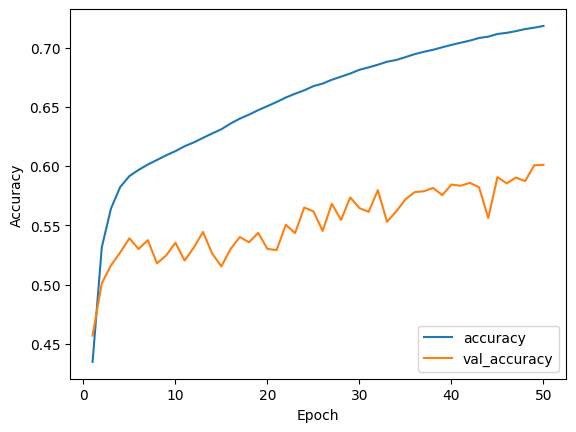

In [103]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)                        
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

<div class="alert alert-block alert-info"><b>Note:</b> Kan nog proberen: meer layers in de x: normalisation, meer dropouts voor overfit, misschien extra *transformer layers*  </div>


#### Experiment 6

Ik wou uitproberen wat er gebeurt als ik een extra transformerlayer toevoeg. En ik wou een stopper toevoegen bij de epochs.

In [16]:
#maak een seq2seq model 
embed_dim = 256 #grootte woord embeddings
dense_dim = 2048 #grootte interne lagen
num_heads = 8 #hoeveel aandachts "hoofden" er zijn (om verschillende aspecten vande zin tegelijk te begrijpen)

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="fries")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) 
#encode de source sentenct

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="nl")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
#Encode the target sentence and combine it with the encoded source sentence
x = layers.Dropout(0.5)(x)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
#predict a word for each output position
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [25]:
early_stopper = EarlyStopping(
    monitor="val_accuracy",     
    patience=10,             # Het aantal epochs zonder verbetering waarna de training stopt
    restore_best_weights=True  # Zorg ervoor dat de beste gewichten worden hersteld
)

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopper])

Epoch 1/50
2718/2718 [==============================] - 461s 167ms/step - loss: 3.4947 - accuracy: 0.5895 - val_loss: 4.1269 - val_accuracy: 0.5264
Epoch 2/50
2718/2718 [==============================] - 441s 162ms/step - loss: 3.4616 - accuracy: 0.5924 - val_loss: 4.1239 - val_accuracy: 0.5248
Epoch 3/50
2718/2718 [==============================] - 438s 161ms/step - loss: 3.4293 - accuracy: 0.5958 - val_loss: 4.0811 - val_accuracy: 0.5288
Epoch 4/50
2718/2718 [==============================] - 440s 162ms/step - loss: 3.4037 - accuracy: 0.5985 - val_loss: 4.1173 - val_accuracy: 0.5309
Epoch 5/50
2718/2718 [==============================] - 438s 161ms/step - loss: 3.3786 - accuracy: 0.6012 - val_loss: 4.1318 - val_accuracy: 0.5251
Epoch 6/50
2718/2718 [==============================] - 440s 162ms/step - loss: 3.3558 - accuracy: 0.6040 - val_loss: 4.1463 - val_accuracy: 0.5248
Epoch 7/50
2718/2718 [==============================] - 438s 161ms/step - loss: 3.3382 - accuracy: 0.6059 - val_

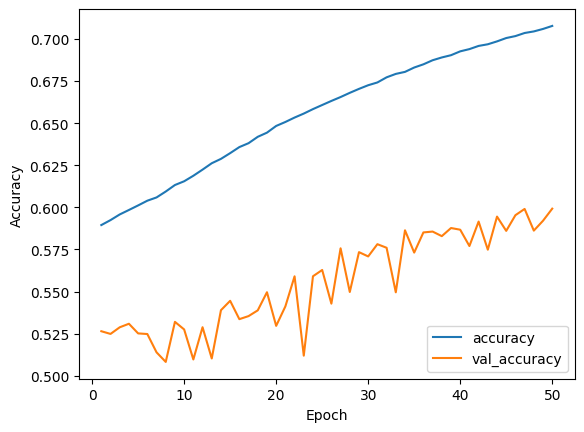

In [27]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)                        
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [26]:
predicted_sentences = []
actual_sentences = []

test_eng_texts = [pair[0] for pair in text_pairs_test]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    predicted_sentence = decode_sequence(input_sentence)
    
    predicted_sentences.append(predicted_sentence)

    actual_sentence = [pair[1] for pair in text_pairs_test if pair[0] == input_sentence][0]
    actual_sentences.append(actual_sentence)

    # Print de zinnen in verschillende kleuren
    print("-")
    print(input_sentence)
    print(f"\033[38;5;214m{predicted_sentence}\033[0m")  # Voorspelde zin in oranje
    print(f"\033[38;5;32m{actual_sentence}\033[0m")  # Echte zin in blauw

-
Haadklasser DOS'46 iepenet snein (14.30 oere) de fjildkompetysje.
[start] miljarden berekenen de gelegenheid de weg de deur neemt [end]
[start] Hoofdklasser DOS'46 opent zondag (14.30 uur) de veldcompetitie. [end]
-
immen fertinke fan [fraude, moard]
[start] iemand van de stichting [end]
[start] iemand verdenken van [fraude, moord] [end]
-
Yn artikel 11.2 fan 'e algemiene bepalingen stiet op hokker wize oft de Maatskippij betelje sil.
[start] in artikel bouwen van de algemene engelachtig staat op welke wijze de lucht aan zal betalen [end]
[start] In artikel 11.2 van de algemene bepalingen staat op welke wijze de Maatschappij zal betalen. [end]
-
(op)skrilje fan
[start] lippen aan [end]
[start] schrikken van [end]
-
De man kriget Joris beet en docht him oan 'e riem.
[start] de man krijgt grote engelachtig aan de maakt hem aan de zak [end]
[start] De man pakt Joris beet en doet hem aan de lijn. [end]
-
De sjoernalist stjoerde it konsept fan syn artikels oars earst nei syn advokaten.
[s

<div class="alert alert-block alert-danger"><b>Niet het verwachtte resultaat:</b> Uiteindelijk na dit model ook 50 epochs te hebben laten draaien, bleek het vorige model toch beter. Daarom zie ik experiment 5 ook als mijn eindmodel </div>

# Evaluatie werkwijze

Ditmaal heb ik de werkwijze van vorige huiswerkopdracht voortgezet. 

Deze werkwijze bevalt mij goed. 

Ik kan met dingen experimenteren en kijken wat het beste werkt. Zo probeer ik puzzelend erachter te komen wat er werkt bij wat voor soort opdracht en beter leren de stof uit de colleges toe te passen.

**Mogelijke verbeterpunten** 

Ik heb mij nu voornamelijk bezig gehouden met het experimenteren met hyperparameters en extra transformerlagen. 
Wat ik nog had kunnen uitproberen om de data te verbeteren was het gedeelte van de tekst die tussen haakjes werd meegegeven en misschien het toevoegen van een andere dataset. 
Dit heb ik gezien mijn planning voor deze week helaas niet meer kunnen proberen.